<a href="https://colab.research.google.com/github/rfarwell/MPhys/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and Importing Libraries


This block makes the necessary installations and imports for the rest of the code blocks to run, connects to the GPU if one is available, and specifies the location of the folder containing the data. That data folder should contain a sub-folder containing all nifti files, along with a clinical data csv file.

In [2]:
!pip install torch torchvision
!pip install opencv-contrib-python
!pip install scikit-learn
!pip install SimpleITK

import numpy as np
import random
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk
import torch

from mpl_toolkits.mplot3d import Axes3D
from torch.nn import Module
from torch.nn import Conv3d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch import nn
from torch import reshape
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torch.optim import Adam
import torchvision.models as models
from torch.autograd import Variable

     |████████████████████████████████| 48.4 MB 2.3 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Connect to GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
# /content/gdrive/MyDrive/MPhys/Data/COLAB-Clinical-Data.csv
# Specify project folder location
project_folder = "/content/gdrive/MyDrive/MPhys/Data"
clinical_data_filename = "COLAB-Clinical-Data.csv"
print(os.path.join(project_folder, clinical_data_filename))

Using cuda device
/content/gdrive/MyDrive/MPhys/Data/COLAB-Clinical-Data.csv


# Defining Functions

In [5]:
def equalise_array_lengths(array_1, array_2) :
  """
  This functions takes in the arguments of two lists and makes sure they are returned as the same length.

  Rory Farwell 02/12/2021
  """
  # output_array = []
  if len(array_1) > len(array_2) :
    array_1 = array_1[:len(array_2)]
  elif len(array_1) < len(array_2) :
    array_2 = array_2[:len(array_1)]
  #print(np.vstack((array_1, array_2)))
  # output_array.append(array_1)
  # output_array.append(array_2)
  return (array_1, array_2)

def remove_same_elements(small_array, long_array) :
  """
  For use in the context, all the elements in small_array come from long_array.
  This function will remove all of the elements used in small_array from_long_array.  
  """
  for element in small_array :
    long_array.remove(element)
  return long_array

def create_subgroup(input_array, original_array_length, desired_percentage) :
  """
  This function outputs a subgroup array (e.g. training array) using a specified output array name,
  input array and percentage length
  """
  desired_length = int(original_array_length * desired_percentage)
  output_array = random.sample(input_array, desired_length)
  return output_array
  

# Define arrays of patient and outcome data

This block allows you to specify the criteria which defines the patient outcome as True or False. It then loops through all the patients in the metadata.csv file, searches for their corresponding image in the image folder, and then adds patient and outcome to either the training, testing, or validation array

In [6]:
# Open the metadata.csv file, convert to an array, and remove column headers
metadata_file = os.path.join(project_folder, clinical_data_filename)
metadata = np.genfromtxt(metadata_file, comments = '%', dtype="str", delimiter=",")
print(f"Length of metadata array is {len(metadata)}")

Length of metadata array is 100


In [7]:
outcome_type = 1 #int(input("Select which outcome you are aiming to predict \n(1=Locoregional, 2=Distant Metastasis, 3=Death):"))
check_day = 3000 #int(input("Select the number of days at which to check for event:"))
which_patients = 1 #int(input("Do you want to include patients whose last follow up is before the check day? (no = 0, yes = 1):"))
patient_with_event = []
patient_no_event = []
outcomes_train = []
outcomes_test = []
images = []

In [8]:
check_day = 365 * 1.5 # This is defining the timeframe for which our CNN will consider the binary output (in days)

patient_IDs = metadata[:,0]
time_markers = metadata[:,8]
dead_statuses = metadata[:,9]

time_markers = time_markers.astype(np.float32)
dead_statuses = dead_statuses.astype(np.float32)



In [9]:
check_day_dead_statuses = []

counter = 0 

dead_counter = 0
alive_counter = 0
no_info_counter = 0

dead_patient_array = []
alive_patient_array = []

for i in range(len(dead_statuses)) :
  # counter+=1
  # print(counter)
  temp_dead_status = dead_statuses[i]
  #print(temp_dead_status)
  temp_time_marker = time_markers[i]
  #print(temp_time_marker)
  if temp_dead_status == 1 : #if the patient is dead
    #print('y')
    if temp_time_marker < check_day :
      check_day_dead_statuses.append(1) #confirms that the patient was dead after time 'check_day'
      dead_patient_array.append([patient_IDs[i], 1])
      dead_counter += 1
      continue
    elif temp_time_marker > check_day :
      check_day_dead_statuses.append(0)
      alive_patient_array.append([patient_IDs[i], 0])
      alive_counter += 1
      continue
  elif temp_dead_status == 0 : #if the patient is alive
    #print('n')
    if temp_time_marker < check_day :
      no_info_counter += 1
      continue
    elif temp_time_marker > check_day :
      check_day_dead_statuses.append(0)
      alive_patient_array.append([patient_IDs[i], 0])
      alive_counter += 1
      continue
print(f"Dead counter after {check_day} days: {dead_counter}")
print(f"Alive counter after {check_day} days: {alive_counter}")
print(f"No-info counter after {check_day} days: {no_info_counter}")

# print(len(dead_patient_array), dead_patient_array)
# print(len(alive_patient_array), alive_patient_array)

training_array = []
testing_array = []
validation_array = []

random.shuffle(dead_patient_array) #shuffling both arrays to ensure random selection of patient data
random.shuffle(alive_patient_array)

# equalising the length of the 'dead' and 'alive' arrays so that we can ensure optimum training proportions
new_dead_patient_array = equalise_array_lengths(dead_patient_array, alive_patient_array)[0]
new_alive_patient_array = equalise_array_lengths(dead_patient_array, alive_patient_array)[1]
print(f"The alive and dead arrays have been sorted (randomly) so that they are both of length {len(new_dead_patient_array)}")

# print(new_dead_patient_array)
# print(new_alive_patient_array)
# print(len(new_dead_patient_array))
# print(len(new_alive_patient_array))

equalised_array_length = len(new_alive_patient_array)

train_patients_dead = create_subgroup(new_dead_patient_array, equalised_array_length, 0.7)
train_patients_alive = create_subgroup(new_alive_patient_array, equalised_array_length, 0.7)
# print(len(train_patients_dead))
# print(len(train_patients_alive))

new_dead_patient_array = remove_same_elements(train_patients_dead, new_dead_patient_array)
new_alive_patient_array = remove_same_elements(train_patients_alive, new_alive_patient_array)
# print(len(new_dead_patient_array))
# print(len(new_alive_patient_array))

test_patients_dead = create_subgroup(new_dead_patient_array, equalised_array_length, 0.15)
test_patients_alive = create_subgroup(new_alive_patient_array, equalised_array_length, 0.15)
# print(len(test_patients_dead))
# print(len(test_patients_alive))

new_dead_patient_array = remove_same_elements(test_patients_dead, new_dead_patient_array)
new_alive_patient_array = remove_same_elements(test_patients_alive, new_alive_patient_array)
# print(len(new_dead_patient_array))
# print(len(new_alive_patient_array))

validate_patients_dead = create_subgroup(new_dead_patient_array, equalised_array_length, 0.15)
validate_patients_alive = create_subgroup(new_alive_patient_array, equalised_array_length, 0.15)
# print(len(validate_patients_dead))
# print(len(validate_patients_alive))

new_dead_patient_array = remove_same_elements(validate_patients_dead, new_dead_patient_array)
new_alive_patient_array = remove_same_elements(validate_patients_alive, new_alive_patient_array)
# print(len(new_dead_patient_array))
# print(len(new_alive_patient_array))




Dead counter after 547.5 days: 60
Alive counter after 547.5 days: 40
No-info counter after 547.5 days: 0
The alive and dead arrays have been sorted (randomly) so that they are both of length 40


In [10]:
outcomes_train = train_patients_dead + train_patients_alive
outcomes_test = test_patients_dead + test_patients_alive
outcomes_validate = validate_patients_dead + validate_patients_alive

# Define dataset class


This block defines the class on which to build dataset objects

In [14]:
import os
from torchvision.io import read_image

In [15]:
class ImageDataset(Dataset) :
  def __init__(self, annotations, img_dir, transform = transforms.ToTensor(), target_transform = None) :
    self.img_labels = annotations
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self) :
    return len(self.img_labels)

  def __getitem__(self,idx) :
    img_path = os.path.join(self.img_dir, self.img_labels[idx][0] + "-GTV-1.nii" )
    image_sitk = sitk.ReadImage(img_path)
    image = sitk.GetArrayFromImage(image_sitk)
    label = self.img_labels[idx][1]
    if self.transform :
      image = self.transform(image)
    if self.target_transform :
      label = self.target_transform(label)
    return image,label

# Build Datasets

This block uses the class and arrays that were defined previously to build datasets for training, testing and validation.

In [16]:
training_data = ImageDataset(outcomes_train, os.path.join(project_folder, "Textured_Masks"))
validation_data = ImageDataset(outcomes_validate, os.path.join(project_folder, "Textured_Masks"))
test_data = ImageDataset(outcomes_test, os.path.join(project_folder, "Textured_Masks"))

# View mask in 3D

This block allows the user to view a binary mask from the image in 3D by extracting the image from a given dataset. This helps to confirm that the data has not been affected by reading in to pytorch.

264


(0.0, 264.0)

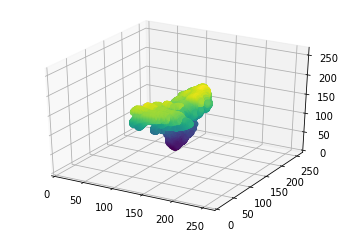

In [17]:
# Set which dataset to look at, and the index of the patient to view
dataset = training_data
index = 4

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

array = dataset[index][0].numpy()
x,y,z = np.where(array > -1024)
ax.scatter(x, y, z, c=z, alpha=1)
print(len(array))

ax.set_xlim(0,len(array))
ax.set_ylim(0,len(array))
ax.set_zlim(0,len(array))

# Dataloader

In [24]:
train_dataloader = DataLoader(training_data, batch_size = 4, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 4, shuffle = True)
validation_dataloader = DataLoader(validation_data, batch_size = 4, shuffle = True)


# Define CNN Class

In [107]:
import torch.functional as F

# class CNN(nn.Module):
#   def __init__(self):
#     super(CNN, self).__init__()
#     self.cnn_layers = nn.Sequential(
#       # Layer 1
#       nn.Conv3d(1,1,4,1,1),
#       nn.BatchNorm3d(1),
#       nn.ReLU(inplace=True),
#       nn.MaxPool3d(kernel_size=2, stride=2),
#       # Layer 2
#       nn.Conv3d(1, 1, 4, 1, 1),
#       nn.BatchNorm3d(1),
#       nn.ReLU(inplace=True),
#       nn.MaxPool3d(kernel_size=2, stride=2),
#     )
#     self.linear_layers = nn.Sequential(
#       nn.Linear(274625, 2)
#     )
#   def forward(self, x):
#     x = self.cnn_layers(x)
#     x = x.view(x.size(0), -1)
#     x = self.linear_layers(x)
#     return x

class CNN(nn.Module) :
  def __init__(self) :
    super(CNN,self).__init__()
    self.conv1 = nn.Conv3d(1, 6, 5)
    self.pool = nn.MaxPool3d(2, 2)
    self.conv2 = nn.Conv3d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 4 * 4 , 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 16)
    self.fc4 = nn.Linear(16, 4)
    self.fc5 = nn.Linear(4, 2)
  
  def forward(self,x) :
    x = self.pool(torch.nn.functional.relu(self.conv1(x)))
    x = self.pool(torch.nn.functional.relu(self.conv2(x)))
    x = x.view(-1, 16 * 4 * 4)
    x = torch.nn.functional.relu(self.fc1(x))
    x = torch.nn.functional.relu(self.fc2(x))
    x = torch.nn.functional.relu(self.fc3(x))
    x = torch.nn.functional.relu(self.fc4(x))
    x = self.fc5(x)
    return x



model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv3d(1, 6, kernel_size=(5, 5, 5), stride=(1, 1, 1))
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(6, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=4, bias=True)
  (fc5): Linear(in_features=4, out_features=2, bias=True)
)


# Define Train and Test Loops

In [108]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = reshape(X, (X.shape[0],1,264,264,264))
        X = X.float()
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = reshape(X, (X.shape[0],1,264,264,264))
            X = X.float()
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

learning_rate = 0.05
# defining the model
model = CNN()
# defining the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# defining the loss function
loss_fn = nn.CrossEntropyLoss()
# checking if GPU is available
model.to(device)
loss_fn.to(device)

CrossEntropyLoss()

# Run Network

In [109]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


RuntimeError: ignored

In [10]:
  array_1=[1,2,3,4,5,6]
  array_2 = [1,2,3,4,5,6,7,8]
  
  if len(array_1) > len(array_2) :
    array_1 = array_1[:len(array_2)]
  elif len(array_1) < len(array_2) :
    array_2 = array_2[:len(array_1)]
    
  print(array_1,array_2)

[1, 2, 3, 4, 5, 6] [1, 2, 3, 4, 5, 6]
